# Exercise 03: Convolutional neural networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torch.distributions.binomial as binomial
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy, softmax

ModuleNotFoundError: No module named 'numpy'

# 1 Introduction

In [5]:
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [34]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w

def init_prelu(shape, value=0.25):
    return torch.full(shape, value, requires_grad=True)

def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])

In [1]:
def calculate_test_error(shape, model, params):
    test_error = 0.0

    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):
            x, y = batch
            x = x.reshape(*shape)
            
            # Forward pass to get predictions 
            noise_py_x = model(*params)
            
            # Apply softmax to get probabilities
            predicted_probs = softmax(noise_py_x, dim=1)
            
            # Get the predicted labels by taking the argmax of the predicted probabilities
            predicted_labels = torch.argmax(predicted_probs, dim=1)
            
            # Compute the number of incorrectly classified samples in this batch
            incorrect_count = torch.sum(predicted_labels != y)
            
            # Accumulate the total number of incorrectly classified samples
            test_error += incorrect_count.item()

    # Compute the average test error across all batches
    total_samples = len(test_dataloader) * batch_size
    test_error /= total_samples

    print(f"Test Error: {test_error * 100:.2f}%") 

# 2 Dropout

In [2]:
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.full_like(X, 1-p_drop))
        return mask * X / (1.0 - p_drop)
    return X


def dropout_model(x, w_h, w_h2, w_o, p_drop_input=0.5, p_drop_hidden=0.5):
    h = rectify(dropout(x @ w_h, p_drop_input))
    h2 = rectify(dropout(h @ w_h2, p_drop_hidden))
    pre_softmax = dropout(h2 @ w_o)
    return pre_softmax


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)


optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

calculate_test_error((batch_size, 784), model, (x, w_h, w_h2, w_o))

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

NameError: name 'init_weights' is not defined

### How the Dropout method works, and how it reduces overfitting
Dropout is a technique where randomly selected neurons are ignored during training, meaning that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. The effect is that the network becomes less sensitive to the specific weights of neurons, and therefore less likely to overfit to the training data.

### Difference with and without Dropout method
With the implemented dropout_model() function, we observe significantly less overfitting. During the first run, the test data shows a loss value of about 0.8, while the training data performs much worse in comparison. Additionally, both training and test sets exhibit decreasing performance over the epochs, suggesting good initialization but poor training behavior.

### Why do we need a different model configuration for evaluating the test loss?
When evaluating the test loss, we use the original model without dropout. This is because dropout is a regularization technique used to prevent overfitting during training, and is not typically used during testing or inference. During testing, we want to use the full capacity of the model, so we don't apply dropout.

# 3 Parametric Relu

In [ ]:
def PRelu(X, a):
    return torch.max(torch.zeros_like(X), X) + torch.mul(a, torch.min(torch.zeros_like(X), X))


def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.full_like(X, 1-p_drop))
        return mask * X / (1.0 - p_drop)
    return X


def dropout_model(x, w_h, w_h2, w_o, a, a2, p_drop_input=0.5, p_drop_hidden=0.5):
    h = PRelu(dropout(x @ w_h, p_drop_input), a)
    h2 = PRelu(dropout(h @ w_h2, p_drop_hidden), a2)
    pre_softmax = dropout(h2 @ w_o)
    return pre_softmax


# define the neural network
def model(x, w_h, w_h2, w_o, a, a2):
    h = PRelu(x @ w_h, a)
    h2 = PRelu(h @ w_h2, a2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

# Initialize PReLU parameter with Gaussian distribution
a = init_prelu((1, w_h.shape[1]))
a2 = init_prelu((1, w_h2.shape[1]))


optimizer = RMSprop(params=[w_h, w_h2, w_o, a, a2])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, a, a2)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o, a, a2)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

calculate_test_error((batch_size, 784), model, (x, w_h, w_h2, w_o, a, a2))


plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### Comparison of Relu and PRelu
We initialized a as proposed by Kaiming He et al. with 0.25. With the use of the Parametric Rectified Linear Unit we are observing essential improvment in the loss rate of our test data as we are approaching a loss of 0.2 as opposed of 0.8 using Relu. The model has also achieved better results for the train data with a loss of 1.2 instead of a loss of 2.4.

# 4 Convolutional Layers

Epoch: 0
Mean Train Loss: 4.84e+00
Mean Test Loss:  2.30e+00
Epoch: 10
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 20
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 30
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 40
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 50
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 60
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 70
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 80
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 90
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 100
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00


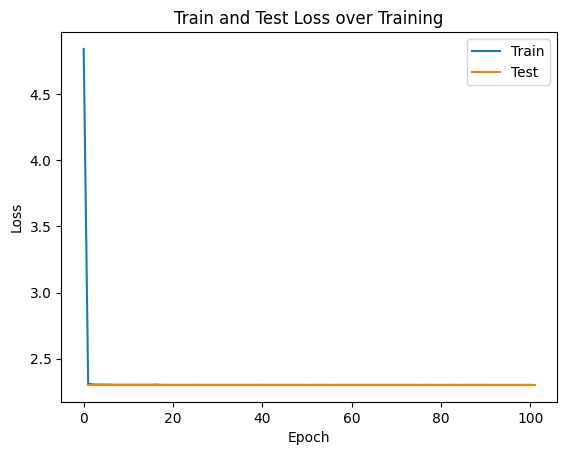

In [35]:
def PRelu(X, a):
    return torch.max(torch.zeros_like(X), X) + torch.mul(a, torch.min(torch.zeros_like(X), X))


def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        mask = torch.bernoulli(torch.full_like(X, 1-p_drop))
        return mask * X / (1.0 - p_drop)
    return X

def convolutional_model(X, w_c1, w_c2, w_c3 , w_h2 , w_o, p_drop):
    # Convolutional layer 1
    convolutional_layer_1 = rectify(conv2d(X, w_c1))
    subsampling_layer_1 = max_pool2d(convolutional_layer_1, (2, 2))
    out_layer_1 = dropout(subsampling_layer_1, p_drop)

    # Convolutional layer 2
    convolutional_layer_2 = rectify(conv2d(out_layer_1, w_c2))
    subsampling_layer_2 = max_pool2d(convolutional_layer_2, (2, 2))
    out_layer_2 = dropout(subsampling_layer_2, p_drop)

    # Convolutional layer 3
    convolutional_layer_3 = rectify(conv2d(out_layer_2, w_c3))
    subsampling_layer_3 = max_pool2d(convolutional_layer_3, (2, 2))
    out_layer_3 = dropout(subsampling_layer_3, p_drop)

    # Flatten the matrix into a 1D tensor
    flattened_input = torch.reshape(out_layer_3, (100,128))

    h2 = rectify(flattened_input @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights
number_of_output_pixels = 128

# convolutional layers
w_c1 = init_weights((32, 1, 5, 5))
w_c2 = init_weights((64, 32, 5, 5))
w_c3 = init_weights((128, 64, 3, 3))

# hidden layer with 625 neurons
w_h2 = init_weights((number_of_output_pixels, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_c1, w_c2, w_c3, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(-1, 1, 28, 28)
        # feed input through model
        noise_py_x = convolutional_model(x, w_c1, w_c2, w_c3, w_h2, w_o, p_drop=0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(-1, 1, 28, 28)
                noise_py_x = convolutional_model(x, w_c1, w_c2, w_c3, w_h2, w_o, p_drop=-1)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

calculate_test_error((-1, 1, 28, 28), convolutional_model, (x, w_c1, w_c2, w_c3, w_h2, w_o, -1))


plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()